In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compound Diagrams

Sometimes, we would like to combine parrallel flows with conditional logic in one Diagram.
While this could always be performed with nested diagrams, it is also possible to create compound diagrams with the use of `Scopes`.

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

class Add():
    def __init__(self,a):
        self.a = a
    def __call__(self,b):
        return self.a+b
    def __str__(self):
        return f'Add({self.a})'

class IsModulo():
    def __init__(self,mod):
        self.mod = mod
    def __call__(self,a):
        return a%self.mod==0
    def __str__(self):
        return f'IsModulo({self.mod})'

class EqualsTo():
    def __init__(self,value):
        self.value = value
    def __call__(self,a):
        return a==self.value
    def __str__(self):
        return f'EqualsTo({self.value})'

In [ ]:
# note the new import
from stringdale import Define,V,E,Condition,Scope


## Flow in Decision

We define a diagram as follows:

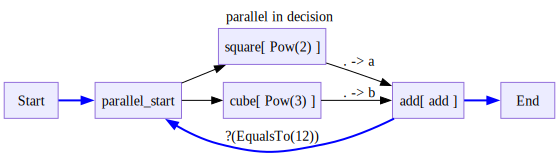

In [ ]:
with Define('parallel in decision',type='decision') as D:
    
    V('parallel_start',inputs=['Start'])
    
    # all edges defined within a flow scope are automatically added as flow edges
    with Scope('flow'):
        V('square',Pow(2),inputs=['parallel_start'])
        V('cube',Pow(3),inputs=['parallel_start'])
        V('add',add,inputs=['square(a)','cube(b)'])
        # we can override the scope and define an edge type explicitly
        E('add->parallel_start',cond=EqualsTo(12),type='decision')
    
    E('add->End')
D.draw()

A legal compound diagram must have a single start and end node for each sub scope.
In this case, `parallel_start` and `add` are the start and end of the flow scope respectivly.

In [ ]:
d = D()
for trace in d.run(3):
    trace.pprint()


Node Start:
{'input': {0: 3}, 'output': 3}
Node parallel_start:
{'input': {0: 3}, 'output': 3}
Node cube:
{'input': {0: 3}, 'output': 27}
Node square:
{'input': {0: 3}, 'output': 9}
Node add:
{'input': {'a': 9, 'b': 27}, 'output': 36}
Node End:
{'input': {0: 36}, 'output': 36}


In [ ]:
d = D()
for trace in d.run(2):
    trace.pprint()


Node Start:
{'input': {0: 2}, 'output': 2}
Node parallel_start:
{'input': {0: 2}, 'output': 2}
Node cube:
{'input': {0: 2}, 'output': 8}
Node square:
{'input': {0: 2}, 'output': 4}
Node add:
{'input': {'a': 4, 'b': 8}, 'output': 12}
Node parallel_start:
{'input': {0: 12}, 'output': 12}
Node square:
{'input': {0: 12}, 'output': 144}
Node cube:
{'input': {0: 12}, 'output': 1728}
Node add:
{'input': {'a': 144, 'b': 1728}, 'output': 1872}
Node End:
{'input': {0: 1872}, 'output': 1872}


## Decision in Flow

We are not limited to a single sub scope.
We can nest them as deep as we want, though above a certain size, its better to use nested diagrams for debug-ability.

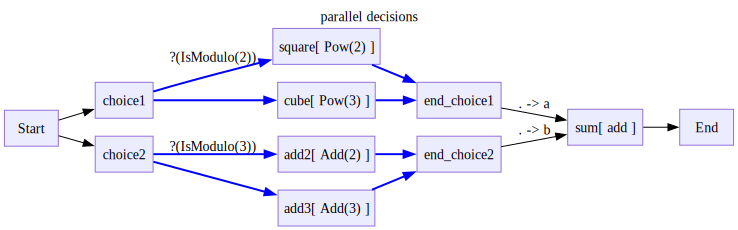

In [ ]:
with Define('parallel decisions',type='flow') as D:
    V('Start',outputs=['choice1','choice2'])
    with Scope('decision'):
        V('choice1',outputs=[
            ('square',IsModulo(2)),
            'cube'
            ])
        V('square',Pow(2),outputs=['end_choice1'])
        V('cube',Pow(3),outputs=['end_choice1'])
        
        V('choice2',outputs=[
            ('add2',IsModulo(3)),
            'add3'
            ])
        V('add2',Add(2),outputs=['end_choice2'])
        V('add3',Add(3),outputs=['end_choice2'])

    V('sum',add,inputs=['end_choice1(a)','end_choice2(b)'],outputs=['End'])
        
D.draw()

In [ ]:
from stringdale.core import checkLogs

Note that even though we defined them in a single decision Scope, we have actually created 2 decision sub scopes.

In [ ]:
d=D()
for trace in d.run(2):
    trace.pprint(skip_passthrough=True)


Node square:
{'input': {0: 2}, 'output': 4}
Node add3:
{'input': {0: 2}, 'output': 5}
Node sum:
{'input': {'a': 4, 'b': 5}, 'output': 9}


In [ ]:
d=D()
for trace in d.run(3):
    trace.pprint(skip_passthrough=True)


Node add2:
{'input': {0: 3}, 'output': 5}
Node cube:
{'input': {0: 3}, 'output': 27}
Node sum:
{'input': {'a': 27, 'b': 5}, 'output': 32}


## Example - Simplifying routing

Let us recall our routing workflow from the decision diagrams tutorial.

In [ ]:
from stringdale.chat import Chat

In [ ]:
rhyming_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following questions using rhyming words.
    """},
    {'role':'user','content':'{{question}}'},
    ],
    )

joke_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke.
    """},
    {'role':'user','content':'{{question}}'},
    ])

yo_mama_chat = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke about the person's mother.
    """},
    {'role':'user','content':'{{question}}'},
    ])

choice_descriptions = {
    'rhyme':'this agent is good at rhyming',
    'joke': 'this agent is good at telling jokes',
    'yo_mama': 'this agent is specifically good at telling jokes about mothers'
}

router = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Choose the best sub-agent to answer the following question from among the following options:
    {% for name,description in choice_descriptions.items() %}
    - {{name}}: {{description}}
    {% endfor %}
    """},
    {'role':'user','content':'{{question}}'},
    ],
    choice_descriptions = choice_descriptions,
    choices=list(choice_descriptions.keys())
    )

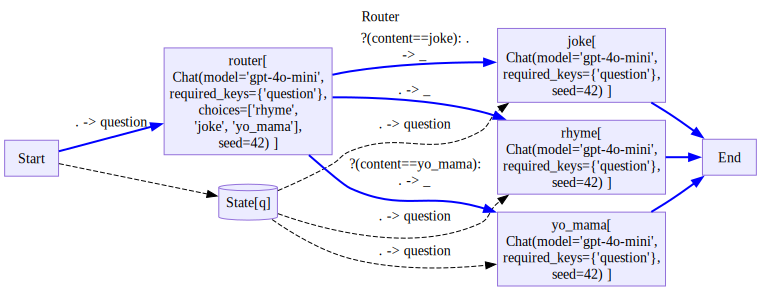

In [ ]:
with Define('Router',type='decision') as Router:
    E('Start->state/q')
    V('router',router,
        inputs=['Start(question=.)'],
        outputs=[
            ('rhyme(_)',),
            ('joke(_)',Condition('joke','(0=content)',name='content==joke')),
            ('yo_mama(_)',Condition('yo_mama','(0=content)',name='content==yo_mama')),
        ]
    )
    V('rhyme',rhyming_agent,
      inputs=['state/q(question=.)'],
      outputs=['End']
    )
    V('joke',joke_agent,
      inputs=['state/q(question=.)'],
      outputs=['End']
    )
    V('yo_mama',yo_mama_chat,
      inputs=['state/q(question=.)'],
      outputs=['End']
    )
Router.draw()

With a flow scope, we can avoid all of these state edges without resorting to nested diagrams.

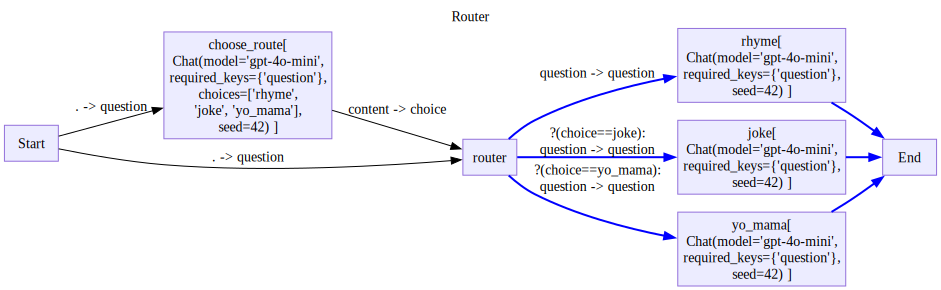

In [ ]:
with Define('Router',type='decision') as CompoundRouter:
    with Scope('flow'):
        V('choose_route',router,inputs=['Start(question=.)'])
        V('router',
            inputs=[
                'choose_route(choice=content)',
                'Start(question=.)'
                ],)

    E('router->rhyme(question=question)')
    E('router->joke(question=question)',cond=Condition('joke','(0=choice)',name='choice==joke'))
    E('router->yo_mama(question=question)',cond=Condition('yo_mama','(0=choice)',name='choice==yo_mama'))
    
    V('rhyme',rhyming_agent,outputs=['End'])
    V('joke',joke_agent,outputs=['End'])
    V('yo_mama',yo_mama_chat,outputs=['End'])

CompoundRouter.draw()

In [ ]:
d = CompoundRouter()
for trace in d.run('what is the capital of france? I like rhyming'):
    trace.pprint(skip_passthrough=True)


Node choose_route:
{ 'input': {'question': 'what is the capital of france? I like rhyming'},
  'output': { 'content': 'rhyme',
              'meta': {'input_tokens': 203, 'output_tokens': 11},
              'role': 'assistant'}}
Node rhyme:
{ 'input': {'question': 'what is the capital of france? I like rhyming'},
  'output': { 'content': 'The capital, oh what a dance, is known as Paris, a '
                         'city of romance.',
              'meta': {'input_tokens': 134, 'output_tokens': 25},
              'role': 'assistant'}}
